# Excercise 1 - sensing Context

Sketch a Context Sensitive Application:

Home Automation with microphones in every room  
=> Asking "Turn on the Light" turns on the Light in the room where the person is located

Trigger = Manual, because it only triggers when the person is saying something  
Output = Command, because the system turns on a light and does not display information  
=> Contextual Command

Relevant Context:
- primarilly the location of the User.  
- potentially the Identity (voice recognition) to check whether a user has permission to turn on the light  
- potentially the Time of Day (prevent Users from turning on light on noon)
- Active Context (behavior which light to turn on)
- Primary Context (location) 

Modification:  
System uses presence sensors and light sensors to automatically turn on the light if the room is dark and there are people present  
=> Trigger becomes automatic without user interaction  
=> Context-triggered action  

# Requirements and Data Loading

In [1]:
!pip install edge-ml pandas seaborn

You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
from edgeml import edgeml

#project = edgeml.getProject("https://app.edge-ml.org","l299ohcWY4KKZNCK4/9DMLVoUX+UqQ01/nle4jmHQ9ZryOKN6Hi0QkW9B69HM1jQS63iPDYar+KYlBbUGURb7g==")

edgeml.getProject throws Bad Gateway Error after couple of Minutes -> Downloaded Datasets as csv from edge-ml website

Renamed deviceorientation.csv to deviceorientation_0.csv (same with motion)

In [3]:
import pandas as pd
import numpy as np
import glob
import os

In [4]:
import json
data_motion = []
data_orientation = []
motion_files = glob.glob(os.path.join(os.path.abspath(''), 'datasets', "devicemotion*.csv"))
orientation_files = glob.glob(os.path.join(os.path.abspath(''), 'datasets', "deviceorientation*.csv"))

for filename in motion_files:
    df = pd.read_csv(filename, index_col='time', header=0)
    metadata = filename.replace(".csv", "_metaData.json")
    with open(metadata) as f:
        d = json.load(f)
        df["participant"] = d["participantId"]
    
    data_motion.append(df)
for filename in orientation_files:
    df = pd.read_csv(filename, index_col='time', header=0)
    metadata = filename.replace(".csv", "_metaData.json")
    with open(metadata) as f:
        d = json.load(f)
        df["participant"] = d["participantId"]
    data_orientation.append(df)   

merged_data_orientation = pd.concat(data_orientation, axis=0)
merged_data_motion = pd.concat(data_motion, axis=0)

In [5]:
# timestamp to datetime
merged_data_orientation.index = pd.to_datetime(merged_data_orientation.index, unit='ms')
merged_data_motion.index = pd.to_datetime(merged_data_motion.index, unit='ms')

In [6]:
data = pd.concat([merged_data_orientation, merged_data_motion], join="outer").sort_index(ascending=True)

In [7]:
data.columns

Index(['sensor_alpha[undefined]', 'sensor_beta[undefined]',
       'sensor_gamma[undefined]', 'label_activities_sitting', 'participant',
       'label_activities_walking', 'label_activities_standing',
       'sensor_alpha[undefined].1', 'label_activities_testing',
       'sensor_x0[undefined]', 'sensor_y0[undefined]', 'sensor_z0[undefined]',
       'sensor_x[undefined]', 'sensor_y[undefined]', 'sensor_z[undefined]'],
      dtype='object')

In [8]:
import re
# remove "[undefined]", "sensor" and "activities" from column names
data = data.rename(columns=lambda x: re.sub('\[undefined\]','',x))
data = data.rename(columns=lambda x: re.sub('sensor_','',x))
data = data.rename(columns=lambda x: re.sub('activities_','',x))

# join sensor_alpha and sensor_alpha.1
data['alpha'] = data[['alpha', 'alpha.1']].max(axis=1)
data = data.drop(['alpha.1'], axis=1)

In [9]:
# Drop all data where no label is present
data = data.dropna(subset=["label_sitting", "label_walking", "label_standing", "label_testing"], how='all')

In [10]:
# Drop Data where index is duplicated (how does this even happen??????)
print("Pre:  " + str(len(data)))
data = data[~data.index.duplicated(keep='first')]
print("Post: " + str(len(data)))

Pre:  136318
Post: 134401


# Revert One-Hot encoding of labels

In [11]:
# fix one-hot encoding from NaN/x to 0/1
data[["label_sitting", "label_walking", "label_standing", "label_testing"]] = data[["label_sitting", "label_walking", "label_standing", "label_testing"]].apply(lambda x: pd.notna(x))

In [12]:
# reverse one-hot encoding of label
data['label'] = data[["label_sitting", "label_walking", "label_standing", "label_testing"]].idxmax(1)

In [13]:
# stringlabel to numerical representation
labels=data["label"].unique().tolist()
data["label"]=data["label"].apply(lambda x: labels.index(x))
data

,alpha,beta,gamma,label_sitting,participant,label_walking,label_standing,label_testing,x0,y0,z0,x,y,z,label
time,,,,,,,,,,,,,,,
2022-05-17 11:01:41.585399808,98.9,39.6,-13.5,True,19514,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,0
2022-05-17 11:01:41.588300032,-9.3,14.1,-5.4,True,19514,False,False,False,0.0,0.1,0.2,1.7,6.4,7.7,0
2022-05-17 11:01:41.602100224,98.6,39.4,-13.0,True,19514,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,0
2022-05-17 11:01:41.605100032,-9.3,14.1,-5.4,True,19514,False,False,False,-0.1,0.1,0.3,1.7,6.4,7.7,0
2022-05-17 11:01:41.615500032,98.3,39.2,-12.5,True,19514,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-19 09:09:50.206899968,21.3,23.8,0.3,False,1b6ed,True,False,False,0.2,-0.1,-0.5,0.6,4.7,8.0,1
2022-10-19 09:09:50.223600128,25.4,22.6,-5.7,False,1b6ed,True,False,False,0.4,0.0,-0.7,0.6,4.9,7.8,1
2022-10-19 09:09:50.240300032,19.9,28.2,-10.9,False,1b6ed,True,False,False,0.4,0.2,-0.9,0.5,5.1,7.6,1


# Windowed Features

In [14]:
aggs={**dict.fromkeys(data.select_dtypes(exclude=[np.float64]).columns, [pd.Series.mode]), 
      **dict.fromkeys(data.select_dtypes(include=[np.float64]).columns, ["mean","var","min","max","median"])}
del aggs["participant"]

In [15]:
data_rolling = data.groupby("participant").rolling("500ms").agg(aggs)

  ERROR: Command errored out with exit status 1:
   command: 'C:\ProgramData\Anaconda3\python.exe' 'C:\Users\Andreas\AppData\Roaming\Python\Python39\site-packages\pip\_vendor\pep517\in_process\_in_process.py' get_requires_for_build_wheel 'C:\Users\Andreas\AppData\Local\Temp\tmpsc9zckyv'
       cwd: C:\Users\Andreas\AppData\Local\Temp\pip-install-tec_u2ti\auto-sklearn_68ec8a105bc94b6bb493442d80017ce1
  Complete output (17 lines):
  Traceback (most recent call last):
    File "C:\Users\Andreas\AppData\Roaming\Python\Python39\site-packages\pip\_vendor\pep517\in_process\_in_process.py", line 363, in <module>
      main()
    File "C:\Users\Andreas\AppData\Roaming\Python\Python39\site-packages\pip\_vendor\pep517\in_process\_in_process.py", line 345, in main
      json_out['return_val'] = hook(**hook_input['kwargs'])
    File "C:\Users\Andreas\AppData\Roaming\Python\Python39\site-packages\pip\_vendor\pep517\in_process\_in_process.py", line 130, in get_requires_for_build_wheel
      return ho

  Using cached auto-sklearn-0.15.0.tar.gz (6.5 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
  Using cached auto-sklearn-0.14.7.tar.gz (6.4 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
  Using cached auto-sklearn-0.14.6.tar.gz (6.4 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
  Using cached auto-sklearn-0.14.5.tar.gz (6.4 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
  Using cached auto-sklearn-0.14.4.tar.gz (6.4 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
  Using cached auto-sklearn-0.14.3.tar.gz (6.3 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (se


    File "<string>", line 1, in <module>
    File "C:\Users\Andreas\AppData\Local\Temp\pip-install-tec_u2ti\auto-sklearn_9f213ba2d0fe463099a0113cfc3ae583\setup.py", line 9, in <module>
      raise ValueError(
  ValueError: Detected unsupported operating system: win32. Please check the compability information of auto-sklearn: https://automl.github.io/auto-sklearn/master/installation.html#windows-osx-compatibility
  ----------------------------------------
  ERROR: Command errored out with exit status 1:
   command: 'C:\ProgramData\Anaconda3\python.exe' -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Andreas\\AppData\\Local\\Temp\\pip-install-tec_u2ti\\auto-sklearn_dfed86656b09435c8130766ac6f0ec71\\setup.py'"'"'; __file__='"'"'C:\\Users\\Andreas\\AppData\\Local\\Temp\\pip-install-tec_u2ti\\auto-sklearn_dfed86656b09435c8130766ac6f0ec71\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from se


  Preparing metadata (setup.py): finished with status 'error'
  Using cached auto-sklearn-0.5.0.tar.gz (3.4 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
  Using cached auto-sklearn-0.4.2.tar.gz (3.4 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'C:\ProgramData\Anaconda3\python.exe' -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Andreas\\AppData\\Local\\Temp\\pip-install-tec_u2ti\\auto-sklearn_a494164251e24b468d581c8f46f900ce\\setup.py'"'"'; __file__='"'"'C:\\Users\\Andreas\\AppData\\Local\\Temp\\pip-install-tec_u2ti\\auto-sklearn_a494164251e24b468d581c8f46f900ce\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\Andreas\AppData\Local\Temp\pip-pip-egg-info-tragx1do'
       cwd: C:\Users\Andreas\AppData\Local\Temp\pip-install-tec_u2ti\auto-sklearn_a494164251e24b468d581c8f46f900ce\
  Complete output (5 lines):
  Traceback (most recent call last):
    File "<string>", line 1, in <module>
    


  Using cached auto-sklearn-0.4.1.tar.gz (3.4 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
  Using cached auto-sklearn-0.4.0.tar.gz (3.4 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
  Using cached auto_sklearn-0.3.0-cp39-cp39-win_amd64.whl
  Using cached ConfigSpace-0.4.21-cp39-cp39-win_amd64.whl (655 kB)
  Using cached pynisher-0.4.2-py3-none-any.whl
  Using cached lockfile-0.12.2-py2.py3-none-any.whl (13 kB)
  Using cached liac_arff-2.5.0-py3-none-any.whl
  Using cached pyrfr-0.7.4.tar.gz (291 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'

  ValueError: Detected unsupported operating system: win32. Please check the compability information of auto-sklearn: http://automl.github.io/auto-sklearn/stable/installation.html#windows-osx-compability
  ----------------------------------------
  ERROR: Command errored out with exit status 1:
   command: 'C:\ProgramData\Anaconda3\python.exe' -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Andreas\\AppData\\Local\\Temp\\pip-install-tec_u2ti\\auto-sklearn_158e9eba4ea74e9fad135c8bcf5a0cf5\\setup.py'"'"'; __file__='"'"'C:\\Users\\Andreas\\AppData\\Local\\Temp\\pip-install-tec_u2ti\\auto-sklearn_158e9eba4ea74e9fad135c8bcf5a0cf5\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\Andreas\AppData\Local\Temp\pip-pip-


  Using cached smac-0.8.0-py3-none-any.whl
  Using cached scikit-learn-0.19.2.tar.gz (9.7 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pyrfr
  Running setup.py clean for scikit-learn
Failed to build pyrfr scikit-learn
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.3
    Uninstalling scikit-learn-1.1.3:


  creating build
  creating build\lib.win-amd64-3.9
  creating build\lib.win-amd64-3.9\sklearn
  copying sklearn\base.py -> build\lib.win-amd64-3.9\sklearn
  copying sklearn\calibration.py -> build\lib.win-amd64-3.9\sklearn
  copying sklearn\cross_validation.py -> build\lib.win-amd64-3.9\sklearn
  copying sklearn\discriminant_analysis.py -> build\lib.win-amd64-3.9\sklearn
  copying sklearn\dummy.py -> build\lib.win-amd64-3.9\sklearn
  copying sklearn\exceptions.py -> build\lib.win-amd64-3.9\sklearn
  copying sklearn\grid_search.py -> build\lib.win-amd64-3.9\sklearn
  copying sklearn\isotonic.py -> build\lib.win-amd64-3.9\sklearn
  copying sklearn\kernel_approximation.py -> build\lib.win-amd64-3.9\sklearn
  copying sklearn\kernel_ridge.py -> build\lib.win-amd64-3.9\sklearn
  copying sklearn\learning_curve.py -> build\lib.win-amd64-3.9\sklearn
  copying sklearn\multiclass.py -> build\lib.win-amd64-3.9\sklearn
  copying sklearn\multioutput.py -> build\lib.win-amd64-3.9\sklearn
  copying s

  copying sklearn\decomposition\setup.py -> build\lib.win-amd64-3.9\sklearn\decomposition
  copying sklearn\decomposition\sparse_pca.py -> build\lib.win-amd64-3.9\sklearn\decomposition
  copying sklearn\decomposition\truncated_svd.py -> build\lib.win-amd64-3.9\sklearn\decomposition
  copying sklearn\decomposition\__init__.py -> build\lib.win-amd64-3.9\sklearn\decomposition
  creating build\lib.win-amd64-3.9\sklearn\decomposition\tests
  copying sklearn\decomposition\tests\test_dict_learning.py -> build\lib.win-amd64-3.9\sklearn\decomposition\tests
  copying sklearn\decomposition\tests\test_factor_analysis.py -> build\lib.win-amd64-3.9\sklearn\decomposition\tests
  copying sklearn\decomposition\tests\test_fastica.py -> build\lib.win-amd64-3.9\sklearn\decomposition\tests
  copying sklearn\decomposition\tests\test_incremental_pca.py -> build\lib.win-amd64-3.9\sklearn\decomposition\tests
  copying sklearn\decomposition\tests\test_kernel_pca.py -> build\lib.win-amd64-3.9\sklearn\decompositi

  creating build\lib.win-amd64-3.9\sklearn\svm\tests
  copying sklearn\svm\tests\test_bounds.py -> build\lib.win-amd64-3.9\sklearn\svm\tests
  copying sklearn\svm\tests\test_sparse.py -> build\lib.win-amd64-3.9\sklearn\svm\tests
  copying sklearn\svm\tests\test_svm.py -> build\lib.win-amd64-3.9\sklearn\svm\tests
  copying sklearn\svm\tests\__init__.py -> build\lib.win-amd64-3.9\sklearn\svm\tests
  creating build\lib.win-amd64-3.9\sklearn\linear_model
  copying sklearn\linear_model\base.py -> build\lib.win-amd64-3.9\sklearn\linear_model
  copying sklearn\linear_model\bayes.py -> build\lib.win-amd64-3.9\sklearn\linear_model
  copying sklearn\linear_model\coordinate_descent.py -> build\lib.win-amd64-3.9\sklearn\linear_model
  copying sklearn\linear_model\huber.py -> build\lib.win-amd64-3.9\sklearn\linear_model
  copying sklearn\linear_model\least_angle.py -> build\lib.win-amd64-3.9\sklearn\linear_model
  copying sklearn\linear_model\logistic.py -> build\lib.win-amd64-3.9\sklearn\linear_mo

In [16]:
# create subdataset with x,y,z variance
data_rolling_var_xyz = data_rolling[[("x","var"),("y","var"),("z","var")]].copy()

In [17]:
# join "var" with x/y/z
data_rolling_var_xyz.columns = data_rolling_var_xyz.columns = ['_'.join(col) for col in data_rolling_var_xyz.columns]
# add label
data_rolling_var_xyz["label"] = data_rolling[("label","mode")].apply(lambda x: labels[int(x)])

In [18]:
data_rolling_var_xyz

x_var     y_var     z_var  \
participant time                                                          
122b5       2022-05-24 13:07:20.209100032       NaN       NaN       NaN   
            2022-05-24 13:07:20.598100224       NaN       NaN       NaN   
            2022-05-24 13:07:20.614600192  0.005000  0.000000  0.000000   
            2022-05-24 13:07:20.626600192  0.005000  0.000000  0.000000   
            2022-05-24 13:07:20.631300096  0.003333  0.000000  0.000000   
...                                             ...       ...       ...   
assf        2022-07-21 20:02:41.524000000  0.748986  0.074136  0.232079   
            2022-07-21 20:02:41.540999936  0.663823  0.055318  0.190493   
            2022-07-21 20:02:41.556999936  0.617790  0.042471  0.168481   
            2022-07-21 20:02:41.574000128  0.583777  0.032922  0.154855   
            2022-07-21 20:02:41.591000064  0.564154  0.031534  0.148238   

                                                   label  
participant time                                          
122b5       2022-05-24 13:07:20.209100032  label_sitting  
            2022-05-24 13:07:20.598100224  label_sitting  
            2022-05-24 13:07:20.614600192  label_sitting  
            2022-05-24 13:07:20.626600192  label_sitting  
            2022-05-24 13:07:20.631300096  label_sitting  
...                                                  ...  
assf        2022-07-21 20:02:41.524000000  label_sitting  
            2022-07-21 20:02:41.540999936  label_sitting  
            2022-07-21 20:02:41.556999936  label_sitting  
            2022-07-21 20:02:41.574000128  label_sitting  
            2022-07-21 20:02:41.591000064  label_sitting  

[134401 rows x 4 columns]

In [19]:
data_rolling_var_xyz_dropped = data_rolling_var_xyz.copy()
data_rolling_var_xyz_dropped.index=data_rolling_var_xyz.index.droplevel()

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

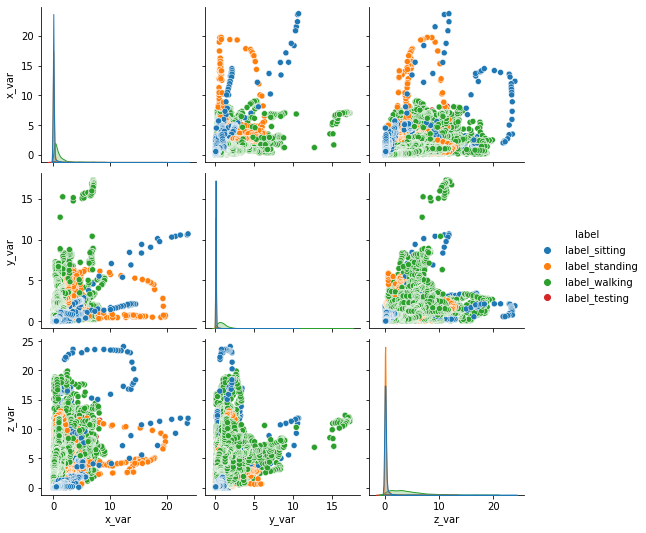

In [23]:
sns.pairplot(data=data_rolling_var_xyz, hue="label")

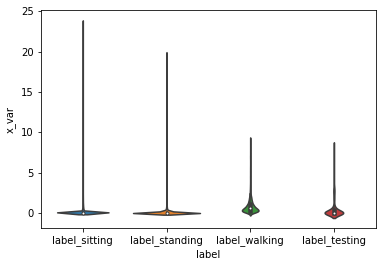

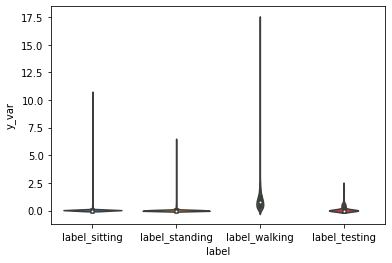

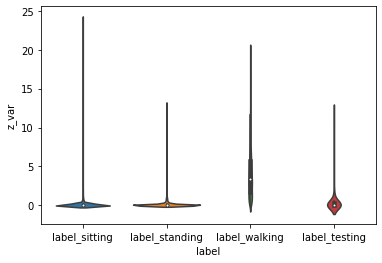

In [24]:
sns.violinplot(data=data_rolling_var_xyz, x="label", y="x_var")
plt.show()
sns.violinplot(data=data_rolling_var_xyz, x="label", y="y_var")
plt.show()
sns.violinplot(data=data_rolling_var_xyz, x="label", y="z_var")
plt.show()

# Model Selection

In [20]:
#dropna and drop where all xyz zero
data_rolling_var_xyz = data_rolling_var_xyz.dropna()
data_rolling_var_xyz = data_rolling_var_xyz[(data_rolling_var_xyz[['x_var','y_var','z_var']] != 0).all(axis=1)]
data_rolling_var_xyz = data_rolling_var_xyz[data_rolling_var_xyz.label != "label_testing"]
data_rolling_var_xyz

x_var     y_var     z_var  \
participant time                                                          
122b5       2022-05-24 13:07:20.731200000  0.001944  0.001111  0.001944   
            2022-05-24 13:07:20.749799936  0.001778  0.001000  0.001778   
            2022-05-24 13:07:20.764499968  0.002182  0.000909  0.001636   
            2022-05-24 13:07:20.781199872  0.002424  0.000833  0.001515   
            2022-05-24 13:07:20.797899776  0.002308  0.000769  0.001923   
...                                             ...       ...       ...   
assf        2022-07-21 20:02:41.524000000  0.748986  0.074136  0.232079   
            2022-07-21 20:02:41.540999936  0.663823  0.055318  0.190493   
            2022-07-21 20:02:41.556999936  0.617790  0.042471  0.168481   
            2022-07-21 20:02:41.574000128  0.583777  0.032922  0.154855   
            2022-07-21 20:02:41.591000064  0.564154  0.031534  0.148238   

                                                   label  
participant time                                          
122b5       2022-05-24 13:07:20.731200000  label_sitting  
            2022-05-24 13:07:20.749799936  label_sitting  
            2022-05-24 13:07:20.764499968  label_sitting  
            2022-05-24 13:07:20.781199872  label_sitting  
            2022-05-24 13:07:20.797899776  label_sitting  
...                                                  ...  
assf        2022-07-21 20:02:41.524000000  label_sitting  
            2022-07-21 20:02:41.540999936  label_sitting  
            2022-07-21 20:02:41.556999936  label_sitting  
            2022-07-21 20:02:41.574000128  label_sitting  
            2022-07-21 20:02:41.591000064  label_sitting  

[102715 rows x 4 columns]

In [21]:
X=data_rolling_var_xyz.drop("label", axis=1)
y=data_rolling_var_xyz["label"]

In [22]:
X

x_var     y_var     z_var
participant time                                                       
122b5       2022-05-24 13:07:20.731200000  0.001944  0.001111  0.001944
            2022-05-24 13:07:20.749799936  0.001778  0.001000  0.001778
            2022-05-24 13:07:20.764499968  0.002182  0.000909  0.001636
            2022-05-24 13:07:20.781199872  0.002424  0.000833  0.001515
            2022-05-24 13:07:20.797899776  0.002308  0.000769  0.001923
...                                             ...       ...       ...
assf        2022-07-21 20:02:41.524000000  0.748986  0.074136  0.232079
            2022-07-21 20:02:41.540999936  0.663823  0.055318  0.190493
            2022-07-21 20:02:41.556999936  0.617790  0.042471  0.168481
            2022-07-21 20:02:41.574000128  0.583777  0.032922  0.154855
            2022-07-21 20:02:41.591000064  0.564154  0.031534  0.148238

[102715 rows x 3 columns]

In [23]:
# get groups (participants) and remove groups from dataframe index
groups = X.index.droplevel(1)
X.index = X.index.droplevel()

X=X.to_numpy()
y=y.apply(lambda x: labels.index(x))

In [24]:
X

array([[0.00194444, 0.00111111, 0.00194444],
       [0.00177778, 0.001     , 0.00177778],
       [0.00218182, 0.00090909, 0.00163636],
       ...,
       [0.61778954, 0.04247126, 0.16848092],
       [0.58377655, 0.0329223 , 0.15485471],
       [0.56415402, 0.03153437, 0.14823782]])

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
#    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]
logo = LeaveOneGroupOut()
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
#    GaussianProcessClassifier(1.0 * RBF(1.0), copy_X_train=False),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10, n_estimators=100, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

# Create test/train split using LeaveOneGoupOut
for train_index, test_index in logo.split(X, y, groups):
    # only use first split because of long execution time
    # optimally do all splits and compare results and/or bagging
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    break




Gaussian Process Crashes local system as well as colab (Memory Error) - therefore skipped

In [31]:
scores = {}
# iterate over classifiers
for name, clf in zip(names, classifiers):
    print("Training " + name)
    scores[name] = {}
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores[name]["score"] = clf.score(X_test, y_test)
    scores[name]["precision_macro"] = precision_score(y_test, y_pred, average='macro')
    scores[name]["precision_micro"] = precision_score(y_test, y_pred, average='micro')
    scores[name]["accuracy"] = accuracy_score(y_test, y_pred)
    scores[name]["recall_macro"] = recall_score(y_test, y_pred, average='macro')
    scores[name]["recall_micro"] = recall_score(y_test, y_pred, average='micro')
    scores[name]["f1_macro"] = f1_score(y_test, y_pred, average='macro')
    scores[name]["f1_weighted"] = f1_score(y_test, y_pred, average='weighted')

Training Nearest Neighbors


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Linear SVM


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training RBF SVM


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Decision Tree


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Random Forest


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Neural Net


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training AdaBoost
Training Naive Bayes
Training QDA


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
for name, clf in zip(names, classifiers):
    y_pred = clf.predict(X_test)
    scores[name]["f1_weighted"] = f1_score(y_test, y_pred, average='weighted')

In [33]:
pd.DataFrame.from_dict(scores).transpose()

,score,precision_macro,precision_micro,accuracy,recall_macro,recall_micro,f1_macro,f1_weighted
Nearest Neighbors,0.605225,0.450892,0.605225,0.605225,0.483106,0.605225,0.404610,0.641021
Linear SVM,0.221646,0.075929,0.221646,0.221646,0.333333,0.221646,0.123684,0.082242
RBF SVM,0.349782,0.421578,0.349782,0.349782,0.388208,0.349782,0.233783,0.312837
Decision Tree,0.679245,0.477341,0.679245,0.679245,0.526180,0.679245,0.449363,0.711843
Random Forest,0.692515,0.480956,0.692515,0.692515,0.531194,0.692515,0.457499,0.724796
Neural Net,0.238026,0.410865,0.238026,0.238026,0.340348,0.238026,0.139542,0.115735
AdaBoost,0.705577,0.488598,0.705577,0.705577,0.540579,0.705577,0.467436,0.737674
Naive Bayes,0.230769,0.409165,0.230769,0.230769,0.337240,0.230769,0.131279,0.100191
QDA,0.234501,0.408940,0.234501,0.234501,0.338839,0.234501,0.134088,0.107250


Best Model based on weighted f1 score:  
RandomForestClassifier(max_depth=10, n_estimators=100, max_features=1)

=> Comparison to 10-fold crossvalidation


In [34]:
from sklearn.model_selection import KFold

tenfold = KFold(10)
# Create test/train split using 10-Fold
for train_index, test_index in logo.split(X, y, groups):
    # only use first split because of long execution time
    # optimally do all splits and compare results and/or bagging
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    break

In [35]:
name = "Random Forest" + "-10-Fold"
clf = RandomForestClassifier(max_depth=10, n_estimators=100, max_features=1)
print("Training " + name)
scores[name] = {}
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
scores[name]["score"] = clf.score(X_test, y_test)
scores[name]["precision_macro"] = precision_score(y_test, y_pred, average='macro')
scores[name]["precision_micro"] = precision_score(y_test, y_pred, average='micro')
scores[name]["accuracy"] = accuracy_score(y_test, y_pred)
scores[name]["recall_macro"] = recall_score(y_test, y_pred, average='macro')
scores[name]["recall_micro"] = recall_score(y_test, y_pred, average='micro')
scores[name]["f1_macro"] = f1_score(y_test, y_pred, average='macro')
scores[name]["f1_weighted"] = f1_score(y_test, y_pred, average='weighted')

Training Random Forest-10-Fold


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
pd.DataFrame.from_dict(scores).transpose().loc[["Random Forest", "Random Forest-10-Fold"]]

,score,precision_macro,precision_micro,accuracy,recall_macro,recall_micro,f1_macro,f1_weighted
Random Forest,0.692515,0.480956,0.692515,0.692515,0.531194,0.692515,0.457499,0.724796
Random Forest-10-Fold,0.690234,0.481230,0.690234,0.690234,0.531332,0.690234,0.456501,0.722644


Using RFE on Random Forest with LOGO
to reduce Features to 2

In [37]:
from sklearn.feature_selection import RFE

for train_index, test_index in logo.split(X, y, groups):
    # only use first split because of long execution time
    # optimally do all splits and compare results and/or bagging
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #break

# new classifier
estimator = RandomForestClassifier(max_depth=10, n_estimators=100, max_features=1)
selector = RFE(estimator, n_features_to_select=2, step=1)
selector = selector.fit(X, y)

In [38]:
selector.support_

array([False,  True,  True])

In [39]:
selector.ranking_

array([2, 1, 1])

In [40]:
name = "Random Forest" + "-2Feature"
print("Training " + name)
scores[name] = {}
y_pred = selector.predict(X_test)
scores[name]["score"] = selector.score(X_test, y_test)
scores[name]["precision_macro"] = precision_score(y_test, y_pred, average='macro')
scores[name]["precision_micro"] = precision_score(y_test, y_pred, average='micro')
scores[name]["accuracy"] = accuracy_score(y_test, y_pred)
scores[name]["recall_macro"] = recall_score(y_test, y_pred, average='macro')
scores[name]["recall_micro"] = recall_score(y_test, y_pred, average='micro')
scores[name]["f1_macro"] = f1_score(y_test, y_pred, average='macro')
scores[name]["f1_weighted"] = f1_score(y_test, y_pred, average='weighted')

Training Random Forest-2Feature


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
pd.DataFrame.from_dict(scores).transpose().loc[["Random Forest", "Random Forest-2Feature", "Random Forest-10-Fold"]]

,score,precision_macro,precision_micro,accuracy,recall_macro,recall_micro,f1_macro,f1_weighted
Random Forest,0.692515,0.480956,0.692515,0.692515,0.531194,0.692515,0.457499,0.724796
Random Forest-2Feature,0.674419,0.333333,0.674419,0.674419,0.224806,0.674419,0.268519,0.805556
Random Forest-10-Fold,0.690234,0.481230,0.690234,0.690234,0.531332,0.690234,0.456501,0.722644


# Ex 5

In [25]:
import random

random.seed(10)

In [26]:
from sklearn.model_selection import LeaveOneGroupOut

logo = LeaveOneGroupOut()
for train_index, test_index in logo.split(X, y, groups):
    # only use first split because of long execution time
    # optimally do all splits and compare results and/or bagging
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    break

In [29]:
# Create Small Subset of Train Data because Gaussian Process needs O(N^2) Memory
flag = [random.random() < 0.05 for _ in range(len(X))]
X_subset = np.array([val for i, val in enumerate(X_train) if flag[i]])
y_subset = pd.Series([val for i, val in enumerate(y_train) if flag[i]])

In [30]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel, random_state=0)
gpc.fit(X_subset, y_subset)
gpc.score(X_subset, y_subset)


0.6232415902140673

In [31]:
name = "Gaussian"
scores[name] = {}
y_pred = gpc.predict(X_test)
scores[name]["score"] = gpc.score(X_test, y_test)
scores[name]["precision_macro"] = precision_score(y_test, y_pred, average='macro')
scores[name]["precision_micro"] = precision_score(y_test, y_pred, average='micro')
scores[name]["accuracy"] = accuracy_score(y_test, y_pred)
scores[name]["recall_macro"] = recall_score(y_test, y_pred, average='macro')
scores[name]["recall_micro"] = recall_score(y_test, y_pred, average='micro')
scores[name]["f1_macro"] = f1_score(y_test, y_pred, average='macro')
scores[name]["f1_weighted"] = f1_score(y_test, y_pred, average='weighted')

NameError: name 'scores' is not defined

In [80]:
scores[name]

{'score': 0.2892390628239685,
 'precision_macro': 0.4159134801081499,
 'precision_micro': 0.2892390628239685,
 'accuracy': 0.2892390628239685,
 'recall_macro': 0.36228023441662227,
 'recall_micro': 0.2892390628239685,
 'f1_macro': 0.1856354825238664,
 'f1_weighted': 0.2124002740754311}

In [1]:
!pip install auto-sklearn

^C


In [ ]:
import numpy as np
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

import autosklearn.classification

In [ ]:
logo = LeaveOneGroupOut()
for train_index, test_index in logo.split(X, y, groups):
    # only use first split because of long execution time
    # optimally do all splits and compare results and/or bagging
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    break

In [ ]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    tmp_folder="/tmp/autosklearn_resampling_example_tmp",
    disable_evaluator_output=False,
    # 'holdout' with 'train_size'=0.67 is the default argument setting
    # for AutoSklearnClassifier. It is explicitly specified in this example
    # for demonstrational purpose.
    resampling_strategy="cv",
    resampling_strategy_arguments={"folds": 5},
)
automl.fit(X_train, y_train, dataset_name="breast_cancer")
y_pred = automl.predict(X_test)
print("Accuracy score holdout: ", sklearn.metrics.accuracy_score(y_test, y_pred))
